#  <span style="color: red;"> Using Nvidia’s research to build a CNN for autonomous driving in Pytorch </span>

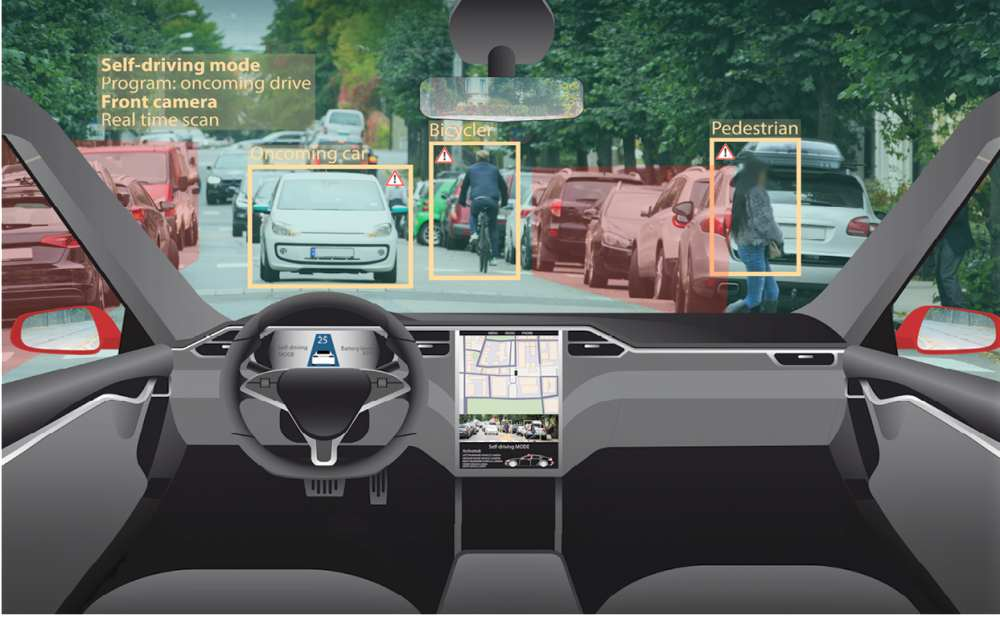


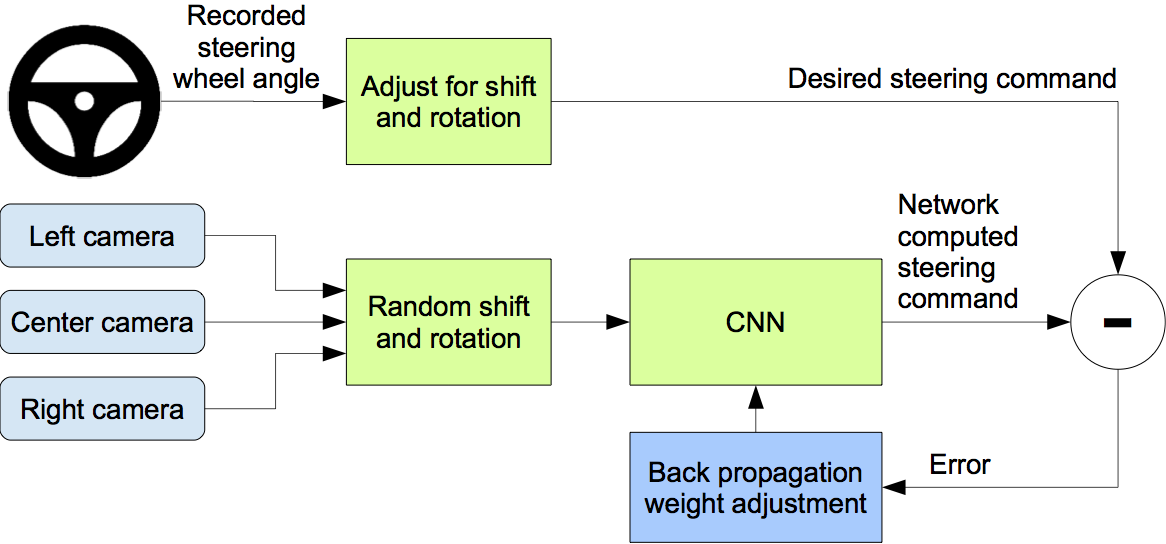

In [ ]:
conda env create -f environments.yml

In [ ]:
conda env create -f environments-gpu.yml

In [ ]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

In [ ]:
# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip

In [ ]:
!unzip data.zip

In [ ]:
conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import cv2
import numpy as np
import csv

# Reading and splitting the data

In [ ]:
# Step1: Read from the log file
samples = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        samples.append(line)

20–30% of training data as the validation set to compare the validation loss and training loss so that we can avoid overfitting.So we are dividing it in 20:80

In [ ]:
train_len = int(0.8*len(samples))
valid_len = len(samples) - train_len
train_samples, validation_samples = data.random_split(samples, lengths=[train_len, valid_len])

### Loading Images in Dataloader
Now that we have made the samples, it is time to read the images and augment them. This is an important step as this will help to generalize our model. But the process is computationally heavy and time-consuming even for GPUs. The trick is to parallelize this process by taking data in batches, augmenting them and sending to the model to train. Keras achieves this process using python generators and the fit_generator function. In Pytorch, we shall use the Dataset class and the Dataloader function to achieve this.

In [ ]:
# Step3a: Define the augmentation, transformation processes, parameters and dataset for dataloader
def augment(imgName, angle):
  name = 'data/IMG/' + imgName.split('/')[-1]
  current_image = cv2.imread(name)
  current_image = current_image[65:-25, :, :]
  if np.random.rand() < 0.5:
    current_image = cv2.flip(current_image, 1)
    angle = angle * -1.0  
  return current_image, angle

Now we define the Dataloader class and pass on this augment function to the input batch samples, concatenate the steering data and images and return it.

In [ ]:
class Dataset(data.Dataset):

    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __getitem__(self, index):
        
        batch_samples = self.samples[index]
        steering_angle = float(batch_samples[3])
        center_img, steering_angle_center = augment(batch_samples[0], steering_angle)
        left_img, steering_angle_left = augment(batch_samples[1], steering_angle + 0.4)
        right_img, steering_angle_right = augment(batch_samples[2], steering_angle - 0.4)
        center_img = self.transform(center_img)
        left_img = self.transform(left_img)
        right_img = self.transform(right_img)
        return (center_img, steering_angle_center), (left_img, steering_angle_left), (right_img, steering_angle_right)
      
    def __len__(self):
        return len(self.samples)

In [ ]:
# Step3b: Creating generator using the dataloader to parallasize the process
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0) - 0.5)])

params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 4}

training_set = Dataset(train_samples, transformations)
training_generator = DataLoader(training_set, **params)

validation_set = Dataset(validation_samples, transformations)
validation_generator = DataLoader(validation_set, **params)

# Model Architecture

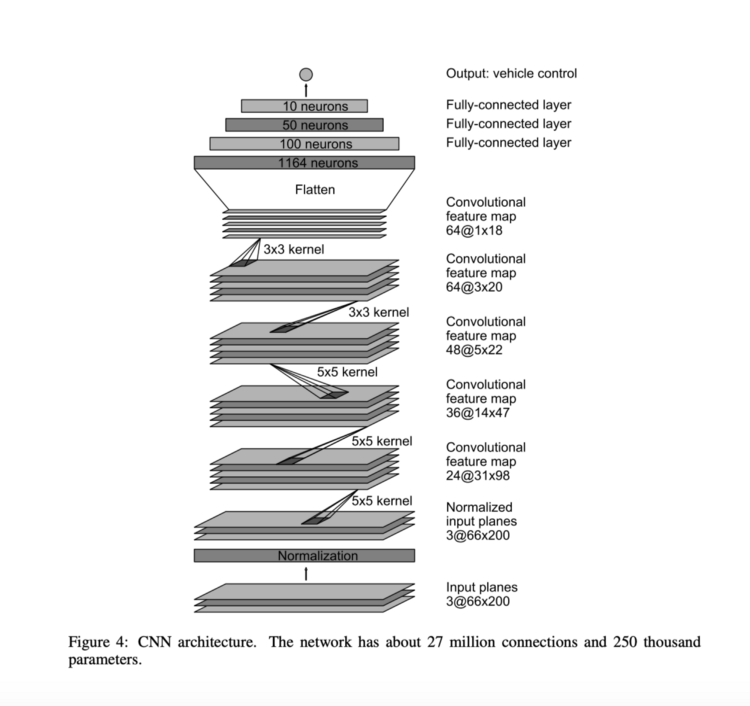

In [ ]:
# Step4: Define the network
class NetworkDense(nn.Module):

    def __init__(self):
        super(NetworkDense, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.25)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64 * 2 * 33, out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )
        
    def forward(self, input):  
        input = input.view(input.size(0), 3, 70, 320)
        output = self.conv_layers(input)
        print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

### elu activation:
The activation function used here is elu (exponential linear unit). Unlike relu (rectified linear unit), elu speeds up the training process and also solves the vanishing gradient problem.

In [ ]:
class NetworkLight(nn.Module):

    def __init__(self):
        super(NetworkLight, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 3, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 48, 3, stride=2),
            nn.MaxPool2d(4, stride=4),
            nn.Dropout(p=0.25)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=48*4*19, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )
        

    def forward(self, input):
        input = input.view(input.size(0), 3, 70, 320)
        output = self.conv_layers(input)
        print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

# Optimizer and Criterion

In [ ]:
# Step5: Define optimizer
model = NetworkLight()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

criterion = nn.MSELoss()

In [ ]:
# Step6: Check the device and define function to move tensors to that device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('device is: ', device)

def toDevice(datas, device):
  
  imgs, angles = datas
  return imgs.float().to(device), angles.float().to(device)

# Training

In [ ]:
max_epochs = 22
for epoch in range(max_epochs):
    model.to(device)
    
    # Training
    train_loss = 0
    model.train()
    for local_batch, (centers, lefts, rights) in enumerate(training_generator):
        # Transfer to GPU
        centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)
        
        # Model computations
        optimizer.zero_grad()
        datas = [centers, lefts, rights]        
        for data in datas:
            imgs, angles = data
#             print("training image: ", imgs.shape)
            outputs = model(imgs)
            loss = criterion(outputs, angles.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.data[0].item()
            
        if local_batch % 100 == 0:
            print('Loss: %.3f '
                % (train_loss/(local_batch+1)))

###  Reference :
1. https://towardsdatascience.com/deep-learning-for-self-driving-cars-7f198ef4cfa2
2. https://github.com/ManajitPal/DeepLearningForSelfDrivingCars